In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os, sys, pickle
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import bptt_rnn as bp  # RNN, learning algorithm, loss function etc
import plot_routines as pr  # plotting functions & directly related
import rot_utilities as ru  # random utilies

%load_ext autoreload
%autoreload 2

In [2]:
single_time_labels = ['0', 'A', '0', 'B', '0', 'C', '0', 'D', '0']
double_time_labels = []
double_time_labels_half = []
for stl in single_time_labels:
    double_time_labels.append(stl)
    double_time_labels.append(stl)
    double_time_labels_half.append(stl)
    double_time_labels_half.append('')
double_time_labels_blank = [x.replace('0', '') for x in double_time_labels]
assert len(double_time_labels_half) == len(double_time_labels)

## Create synthetic data
There are 8 possible values: 
- 0 $blank/0$
- 1 $A_1$
- 2 $A_2$
- 3 $B_1$
- 4 $B_2$
- 5 $C_1$
- 6 $C_2$
- 7 $D$

Data points are thus 8-dim vectors, with:

$z_{k, t} = (1_{0}, 1_{A_1}, 1_{A_2}, ... , 1_{D})$

where $k$ is the trial index, and $t$ is the trial time. Hence $|z_{k, t}| = 1 $ before white noise is added. Trials will be either $T=9$ data points long (single), and of form:

$ 0, A_{\alpha}, 0, B_{\alpha}, 0, C_{\beta}, 0, D, 0 $

or of length $T=18$ (double), and of form:

$ 0, 0, A_{\alpha}, A_{\alpha}, 0, 0, B_{\alpha}, B_{\alpha}, 0, 0, C_{\beta}, C_{\beta}, 0, 0, D, D, 0, 0 $

where $\alpha, \beta \in (1, 2)$, although one can use shorter sequences for testing (e.g. $0, A_{\alpha}, 0, B_{\alpha}, 0$). The expected sequence is $\alpha = \beta$, and the unexpected sequence is $\alpha \neq \beta$.

Network input $x_k = z_{k, 0:T-1}$ and output $y_k = z_{k, 1:T}$. 

In [3]:
d_dict = {  # data parameters dictionary
        'n_total': 1000,  # total number of data sequences
        'n_freq': 8,  # blank through D
        'n_times': 9,
        'doublesse': True,
        'ratio_train': 0.8,
        'ratio_exp': 0.5,  # probabilities of switching between alpha nd beta
        'noise_scale': 0.1
        }
if d_dict['doublesse']:
    eval_times = np.arange(4, 17)  # double
    d_dict['sequence'] = np.array(double_time_labels)
elif d_dict['doublesse'] is False:
    eval_times = np.arange(1, 8)  # single
    d_dict['sequence'] = np.array(single_time_labels)
t_dict = {'eval_times': eval_times}  # training paramter dictionary

freq_labels = ['0', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2', 'D']
tmp0, tmp1 = bp.generate_synt_data(n_total=d_dict['n_total'], 
                                   n_times=d_dict['n_times'], 
                                   n_freq=d_dict['n_freq'],
                                   ratio_train=d_dict['ratio_train'], 
                                   ratio_exp=d_dict['ratio_exp'], 
                                   noise_scale=d_dict['noise_scale'], 
                                   double_length=d_dict['doublesse'])
x_train, y_train, x_test, y_test = tmp0
labels_train, labels_test = tmp1

## RNN Model with BPTT

#### RNN model:

$(x_t, s_{t-1}) \to s_t \to \hat{y}_t == y_t = x_{t+1} $

within one trial $k$. 
Equations:

$s_t = \tanh( U \cdot x_t + W \cdot s_{t-1})$


$\hat{y}_t = softmax(V \cdot s_t) = \left( \frac{e^{V_i \cdot s_t}}{\sum_i e^{V_i \cdot s_t}} \right), \; for \; i \in (0, A_1, A_2 ... D)$

where $U_{n x f}, W_{n x n}, V_{f x n}$ are matrices where $n$ is the number of RNN nodes and $f$ the number of input/output frequencies.

#### Training procedure:

The full sequence $x_k$ is forwarded through the model, yielding $\hat{y}_k$. This is used to compute the loss function $L$, which error is backpropagated through time (BPTT) to the parameters $\theta = (U, W, V)$ (updated with SGD probably). 
The loss function $L$ uses cross entropy and L1 regularisation:

$L_k = \sum_{\tau} - y_{k, \tau} \log \hat{y}_{k, \tau} + \lambda \cdot ||\theta||_1$

where $\tau$ defines the trial times that are taken into account for Loss computation. 

$ \begin{equation}
    \tau =
    \begin{cases}
      (0, 1, 2, ... 8), & \text{all} \\
      (1, 3, 5, 7), & \text{non-blank (nb)}\\
      (3, 5, 7), & \text{non-initial nb (ninb)}
    \end{cases}
  \end{equation}$

#### Initial conditions:

Tricky.. Maybe start on each trials with either zero, or small-magnitude noise, for $s_{k, -1}$? The sequence $0, A_{\alpha}, 0$ then should provide a sensible initialisation, needed for $B_{\alpha}$ prediction... ?  


#### Pseudo-algorithm:

    for $it$ in epochs:
        for $k$ in trials:
            for $t$ in times:
                rnn.forward($x_t$)
            compute loss $L_k$
            update parameters with BPTT


In [4]:
## Set training parameters:
t_dict['n_nodes'] = 20  # number of nodes in the RNN 
if d_dict['doublesse']:
    t_dict['learning_rate'] = 0.002  # algorithm lr
elif d_dict['doublesse'] is False:
    t_dict['learning_rate'] = 0.05
t_dict['bs'] = 1  # batch size
t_dict['n_epochs'] = 40  # training epochs
t_dict['l1_param'] = 5e-4  # L1 regularisation in loss function
t_dict['check_conv'] = False  # check for convergence (and abort if converged)
t_dict['conv_rel_tol'] = 5e-4  # assess convergence by relative difference between two epochs is smaller than this 


## Train one single model

In [41]:
## Initiate RNN model
rnn = bp.RNN(n_stim=d_dict['n_freq'], n_nodes=t_dict['n_nodes'])  # Create RNN class
opt = torch.optim.SGD(rnn.parameters(), lr=t_dict['learning_rate'])  # call optimiser from pytorhc
rnn.set_info(param_dict={**d_dict, **t_dict})

In [42]:
## Train with BPTT
rnn = bp.bptt_training(rnn=rnn, optimiser=opt, dict_training_params=t_dict,
                x_train=x_train, x_test=x_test, y_train=y_train, y_test=y_test)

Epoch 11/40. Train loss: 0.746895:  28%|██▊       | 11/40 [00:55<02:27,  5.09s/it]     

Training ended prematurely by user at epoch 11.
Results saved in RNN Class.


In [43]:
rnn.save_model()

RNN model saved as models/rnn_2020-05-06-0956.data


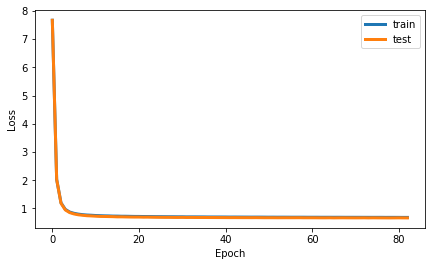

In [25]:
## Plot train/test loss during training
plt.rcParams['figure.figsize'] = (7, 4)
ax_conv = pr.plot_train_test_perf(rnn_model=rnn, ax=plt.subplot(111))

Trial type: 22


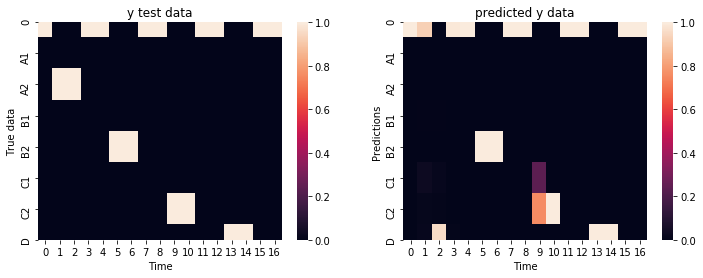

In [26]:
## Plot example test sample & prediction
k = 0
print(f'Trial type: {labels_test[k]}')
pred = bp.compute_full_pred(x_test[k,:,:], model=rnn)
plt.rcParams['figure.figsize'] = (12, 4)

plt.subplot(121)
sns.heatmap(y_test[k, :, :].numpy().T, yticklabels=freq_labels)
plt.title("y test data"); plt.xlabel('Time'); plt.ylabel('True data')

plt.subplot(122)
sns.heatmap(pred.mean(0).detach().numpy().T, vmax=1, vmin=0, yticklabels=freq_labels)
plt.title("predicted y data"); plt.xlabel('Time'); plt.ylabel("Predictions");

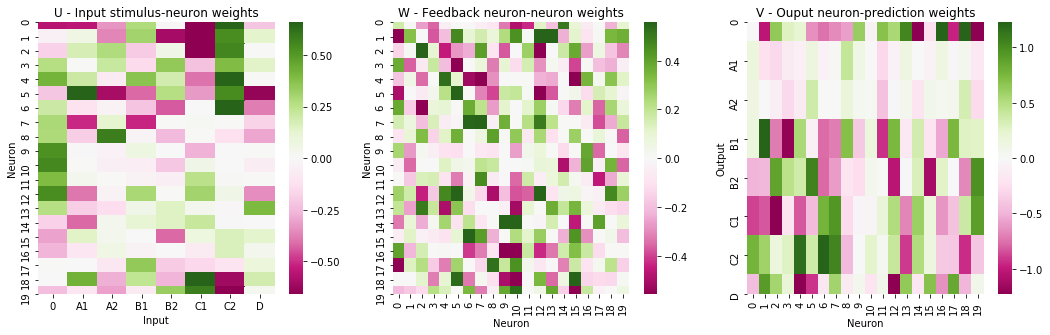

In [27]:
## Plot weight matrices U, W, V
plt.rcParams['figure.figsize'] = (18, 5)
w_order = pr.opt_leaf(w_mat=rnn.lin_input, dim=0)
_ = pr.plot_all_UWV(rnn_model=rnn, freq_labels=freq_labels, weight_order=w_order)

## Cross temporal decoding

Each sequence $seq_k$ has labels $\alpha, \beta$. We wish to decode $\alpha$ dynamically per time point, in a cross-temporal manner, from the RNN hidden state $s_t$. Id est, we will create a decoder $dec(t | \tau) = P(\alpha = 1 | \tau)_t$ that is trained at time $\tau$ but evaluated at time $t$. We can choose to train our decoder with either or both $(\alpha = \beta)$ and $(\alpha \neq \beta)$ sequences. To decode, we will use a linear SVM with L2 regularisation (from sklearn). 

#### Pseudocode

    forward run of all trials
    for $\tau$ in T:
        train P($\alpha$ | $\tau$)
        for t in T:
            evaluate P($\alpha$ | $\tau$)_t

In [28]:
score_mat, decoder_dict = bp.train_decoder(rnn_model=rnn, x_train=x_train, x_test=x_test,
                                           labels_train=labels_train, labels_test=labels_test,
                                           dict_training_params=t_dict)

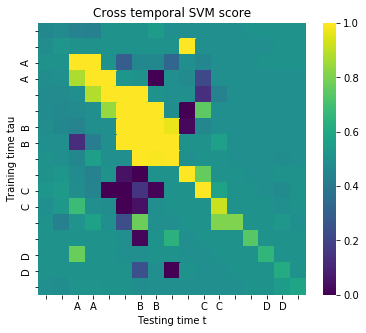

In [29]:
# score_mat[0, 5] = -10
plt.rcParams['figure.figsize'] = (6, 5)
ax_score = pr.plot_decoder_crosstemp_perf(score_matrix=score_mat, ax=plt.subplot(111),
                               ticklabels=double_time_labels_blank[:-1])

In [ ]:
angle_change = np.zeros(x_train.shape[1] - 1)
for tau in range(x_train.shape[1] - 1):
    angle_change[tau] = np.sum(np.abs(decoder_dict[tau].coef_ - decoder_dict[tau + 1].coef_))
    
plt.rcParams['figure.figsize'] = (5, 3)
f, ax_ac = plt.subplots(1, 1)
ax_ac.plot(angle_change, linewidth=3)
ax_ac.set_xlabel('Time t'); ax_ac.set_ylabel('L1 norm between t and (t + 1)')
ax_ac.set_title('Instanteous change in decoder')
ax_ac.set_xticks(np.arange(len(angle_change)));
ax_ac.set_xticklabels(double_time_labels_blank[:-2]);

In [ ]:
decoder_axes = np.zeros((decoder_dict[0].coef_.size, len(decoder_dict)))
for k, v in decoder_dict.items():
    decoder_axes[:, k] = v.coef_
cutoff_w = np.percentile(np.abs(decoder_axes), 95)
plt.rcParams['figure.figsize'] = (4, 6)
ax_dec_diag = plt.subplot(3, 1, 1)
ax_dec_diag.plot(np.diag(score_mat), linewidth=3)
ax_dec_diag.set_ylabel('Score')
ax_dec_diag.set_title('Decoding performance (t = tau)')
ax_dec_diag.set_xticks(np.arange(len(np.diag(score_mat))));
ax_dec_diag.set_xticklabels(double_time_labels_blank[:-1]);
ax_dec_diag.set_xlim([-0.5, len(np.diag(score_mat)) - 0.5])
plt.subplot(3, 1, (2, 3))
ax_dec_w = sns.heatmap(decoder_axes, xticklabels=double_time_labels_blank[:-1],
                      vmin=-1 * cutoff_w, vmax=cutoff_w, cmap='PiYG', cbar=False)
bottom, top = ax_dec_w.get_ylim()
ax_dec_w.set_ylim(bottom + 0.5, top - 0.5)
plt.xlabel('Time t'); plt.ylabel('Neuron');

In [ ]:
plt.imshow(forw_mat['train'][12, :, :].T - forw_mat['train'][0, :, :].T, 
           vmax=0.75, vmin=-0.75, cmap='PiYG')
plt.colorbar()

## Train & save multiple models

In [ ]:
## Train a lot of models for saving:
_ = bp.init_train_save_rnn(t_dict=t_dict, d_dict=d_dict, 
                           n_simulations=100, save_folder='models/5050_Xmodels/')

Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]


-----------
simulation 0/100


Epoch 39/40. Train loss: 0.815417: 100%|██████████| 40/40 [03:05<00:00,  4.64s/it]     


Training finished. Results savedin RNN Class


Initialising training; start at epoch 0:   0%|          | 0/40 [00:00<?, ?it/s]

RNN model saved as models/5050_Xmodels/rnn_2020-05-06-1033.data

-----------
simulation 1/100


Epoch 11/40. Train loss: 0.862911:  28%|██▊       | 11/40 [00:52<02:23,  4.96s/it]     

In [76]:
agg_conv = bp.aggregate_convergence(model_folder='models/7525_100models/')
agg_score = bp.aggregate_score_mats(model_folder='models/7525_100models/')

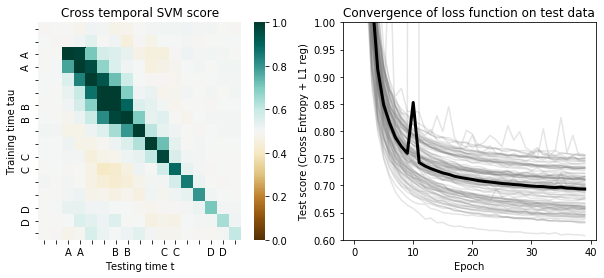

In [88]:
plt.rcParams['figure.figsize'] = (10, 4)
# plt.subplots_adjust(wspace=0.6)
fig, ax_agg = plt.subplots(1, 2)
pr.plot_decoder_crosstemp_perf(score_matrix=np.mean(agg_score, 0), 
                               ax=ax_agg[0], ticklabels=double_time_labels_blank[:-1])

ax_agg[1].plot(agg_conv['test'][:100, :].T, alpha=0.2, c='grey')
ax_agg[1].plot(np.mean(agg_conv['test'], 0), linewidth=3, c='k')
ax_agg[1].set_ylim([0.6, 1]); ax_agg[1].set_ylabel('Test score (Cross Entropy + L1 reg)')
ax_agg[1].set_xlabel('Epoch'); ax_agg[1].set_title('Convergence of loss function on test data');